In [10]:
from __future__ import division
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 0. Data Preparation

## 0.1. Read Data

In [44]:
df = pd.read_excel("TBA_mod.xlsx")  # TBA
FN_issue = pd.read_csv("FN_issuance.csv")  # issuance 
rr_daily = pd.read_excel("ILM3NAVG_daily.xlsx") # Use Bankrate.com US Home Mortgage 30year Fixed Natinal Avg

## 0.2. Clean Data

In [45]:
l = df.loc[0].values
c = df.columns
for ind in np.arange(8)*3:
    l[ind] = c[ind]

df.columns = l
df.drop(0)
FN_issue.index = FN_issue['Date']
del FN_issue['Date']
rr_daily.index = rr_daily['Date']
del rr_daily['Date']
rr_daily.columns = ['Last rate', 'Mid rate']

# FN_issue.head()

**For each month find the max issuance bond and use this to generate the price and yield relation**

In [46]:
Most_issue = []
for i in FN_issue.index:
    Most_issue.append(float(np.argmax(FN_issue.loc[i]).split()[4][:-1]))

**Plot the monthly most issued coupon rate vs. reference rate**

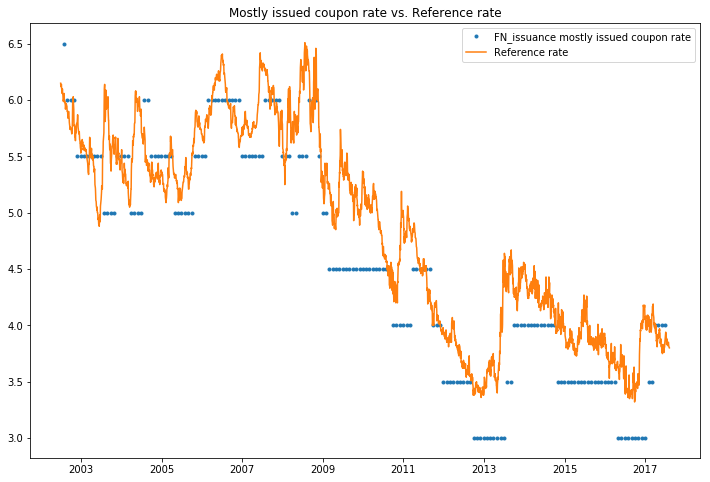

In [83]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot_date(FN_issue.index, Most_issue, label = 'FN_issuance mostly issued coupon rate', markersize = 3)
ax.plot_date(rr_daily.index,rr_daily['Mid rate'],'-',label = 'Reference rate')
ax.set_title("Mostly issued coupon rate vs. Reference rate")
ax.legend()

### Observation : This figure shows that the issuance data is highly correlated with the Bankrate.com US Home mortgage 30 year fixed national Avg.

**TBA data at each coupon rate**

In [53]:
FNCL3 = df.iloc[:,:3].drop(0).dropna().copy()
FNCL3.index = FNCL3['FNCL 3.0 Mtge']
del FNCL3['FNCL 3.0 Mtge']

FNCL3_5 = df.iloc[:,3:6].drop(0).dropna().copy()
FNCL3_5.index = FNCL3_5['FNCL 3.5 Mtge']
del FNCL3_5['FNCL 3.5 Mtge']

FNCL4 = df.iloc[:,6:9].drop(0).dropna().copy()
FNCL4.index = FNCL4['FNCL 4 Mtge']
del FNCL4['FNCL 4 Mtge']

FNCL4_5 = df.iloc[:,9:12].drop(0).dropna().copy()
FNCL4_5.index = FNCL4_5['FNCL 4.5 Mtge']
del FNCL4_5['FNCL 4.5 Mtge']

FNCL5 = df.iloc[:,12:15].drop(0).dropna().copy()
FNCL5.index = FNCL5['FNCL 5 Mtge']
del FNCL5['FNCL 5 Mtge']

FNCL5_5 = df.iloc[:,15:18].drop(0).dropna().copy()
FNCL5_5.index = FNCL5_5['FNCL 5.5 Mtge']
del FNCL5_5['FNCL 5.5 Mtge']

FNCL6 = df.iloc[:,18:21].drop(0).dropna().copy()
FNCL6.index = FNCL6['FNCL 6 Mtge']
del FNCL6['FNCL 6 Mtge']

FNCL6_5 = df.iloc[:,21:].drop(0).dropna().copy()
FNCL6_5.index = FNCL6_5['FNCL 6.5 Mtge']
del FNCL6_5['FNCL 6.5 Mtge']

list_df = [FNCL3, FNCL3_5, FNCL4 , FNCL4_5, FNCL5, FNCL5_5, FNCL6, FNCL6_5]

ind = [int(i-3)*2 for i in Most_issue]

**TBA data to use in each time period. Pick the TBA data with coupon = mostly issued coupon rate at each time point**

In [54]:
totel = []
for t, i in zip(FN_issue.index, ind):
    t1 = dt.datetime.strptime(t,'%d-%b-%y')
    t_end = t1 + dt.timedelta(1)
    t_start = dt.datetime(t1.year,t1.month,1) - dt.timedelta(1)
    
    temp =  list_df[i].iloc[(list_df[i].index > t_start) & (list_df[i].index < t_end)].copy()
    temp['coupon'] = i/2 +3
    totel.append(temp)

result = pd.concat(totel)

**Price change**

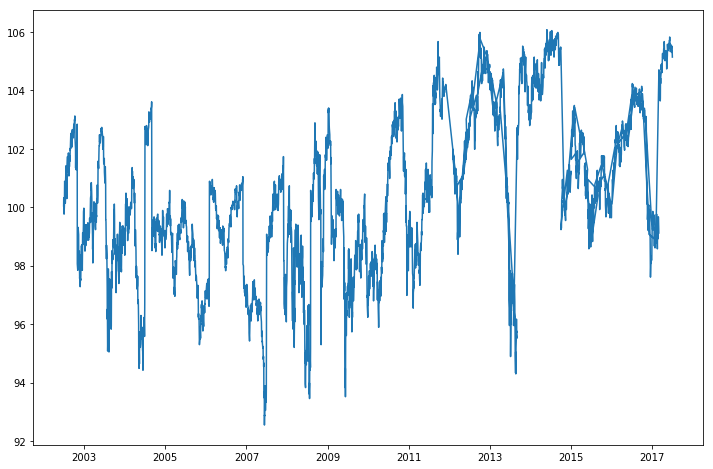

In [56]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(result['PX_MID'])

**Merge TBA data with reference rate data**

Here we define a new data column **spread** = Reference Rate - Coupon Rate. Our yearly rolling regression will be based on this spread

In [61]:
Merged_df = pd.concat([rr_daily, result], axis=1, join='inner')
Merged_df['spread'] = Merged_df['Last rate'] - Merged_df['coupon']
Merged_df['year'] = Merged_df.index.year

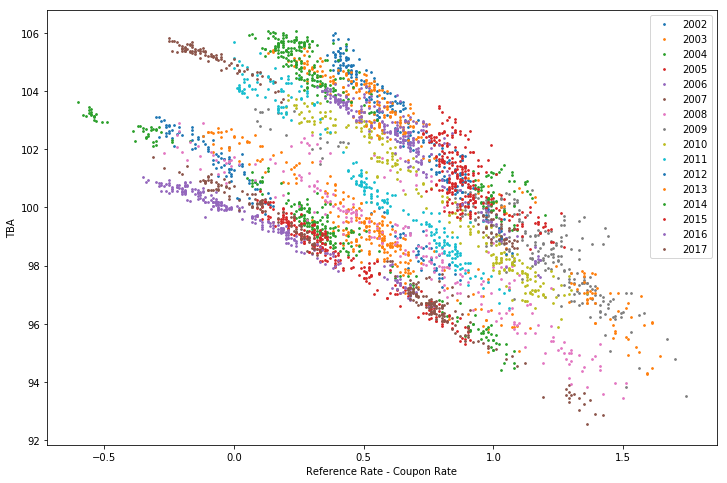

In [71]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
for y in np.arange(2002, 2018):
    ax.scatter(Merged_df[Merged_df.year == y]['spread'],Merged_df[Merged_df.year == y]['PX_MID'], s = 3, label = y)
ax.legend()
ax.set_xlabel('Reference Rate - Coupon Rate')
ax.set_ylabel('TBA')

# 1. Rolling Regression - Yearly Basis

Run regression on TBA against spread for each year

In [144]:
precision = 4

def reg(year, fig):
    dff = Merged_df.iloc[(Merged_df.index < dt.datetime(year+1,1,1)) & \
                         (Merged_df.index > dt.datetime(year-1,12,31))].copy()
    mod = sm.OLS(dff['PX_MID'].values , sm.add_constant(dff['spread'].values))
    res = mod.fit()
    a, b = res.params
    x = np.linspace(min(dff['spread'].values),max(dff['spread'].values))
    y = [a+b*i for i in x]
    ax = fig.add_subplot(8,2,year - 2001)
    ax.plot(x, y,color = 'r',label='fit')
    ax.scatter(dff['spread'].values,dff['PX_MID'].values,label = 'real',s=4)
    symb = ' + ' if b >= 0 else ''
    ax.set_title('year ' + str(year) + ' : ' + str(round(a, precision)) + symb + str(round(b, precision)) + 'x')
    ax.legend()
    ax.set_xlabel('spread')
    ax.set_ylabel('TBA')
    
    return b

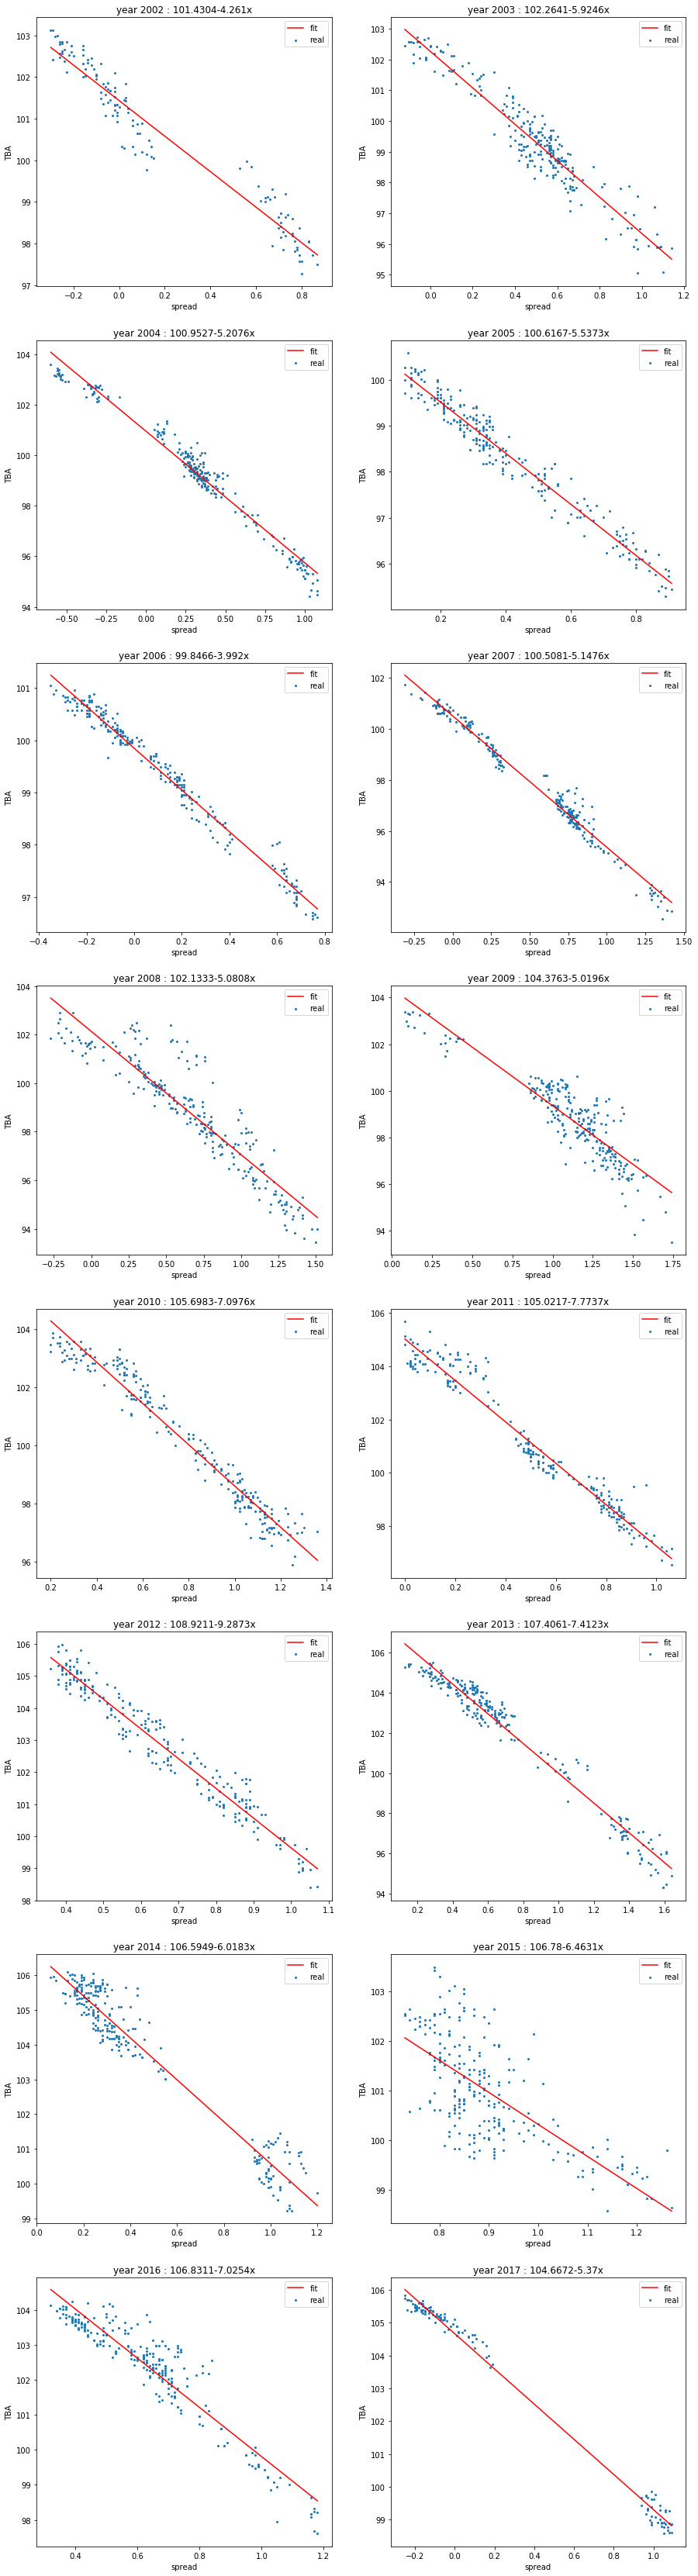

In [145]:
fig = plt.figure(figsize = (15, 60))
ds = []

for i in range(2002,2018):
    ds.append(reg(i, fig))

**Duration change against time**

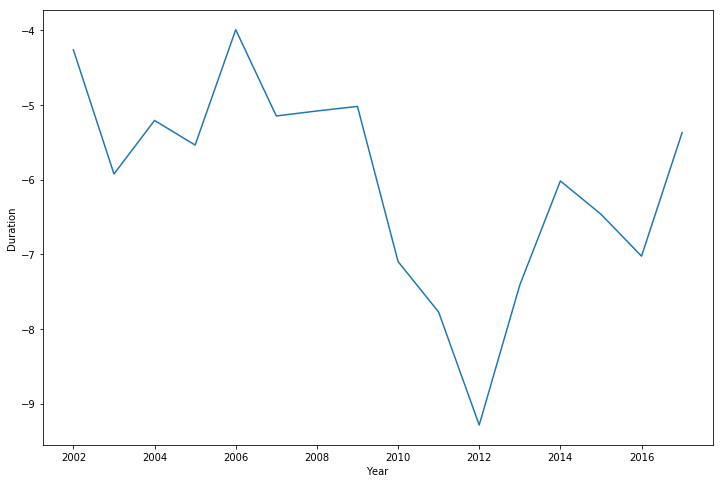

In [122]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(np.arange(2002, 2018), ds)
ax.set_xlabel('Year')
ax.set_ylabel('Duration')

**Observation: We observed different intercepts and slops in the regressions of yearly rolling window. A moderate shift from 102 to 106 might because the low rates in the 2012-2017. There might be a prepayment premium compensate for the low rate/coupon. 
Next stages, we will consider more exogenous variables such as HPI, GDP, etc. **

# 2. Rolling Regression - Constant Coupon

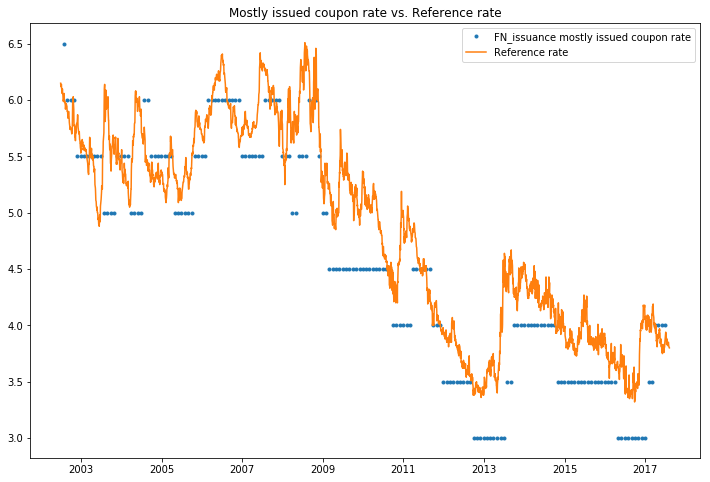

In [125]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot_date(FN_issue.index, Most_issue, label = 'FN_issuance mostly issued coupon rate', markersize = 3)
ax.plot_date(rr_daily.index,rr_daily['Mid rate'],'-',label = 'Reference rate')
ax.set_title("Mostly issued coupon rate vs. Reference rate")
ax.legend()

**The chart shows coupon rate are constant during certain periods. We choose the constant coupon rate period as rolling window. The intuition is that change in mostly issued coupon rate is due to changes in some fundamental factors to be explored. So within a constant coupon period, we could consider it as a constant regime**

In [141]:
samples = []
cur_coupon = Merged_df.iloc[0].coupon
start_index = 0
for i in np.arange(1, Merged_df.shape[0]):
    if Merged_df.iloc[i].coupon != cur_coupon:
        samples.append(Merged_df.iloc[start_index:i-1])
        start_index = i
        cur_coupon = Merged_df.iloc[i].coupon
samples.append(Merged_df.iloc[start_index:Merged_df.shape[0] - 1])

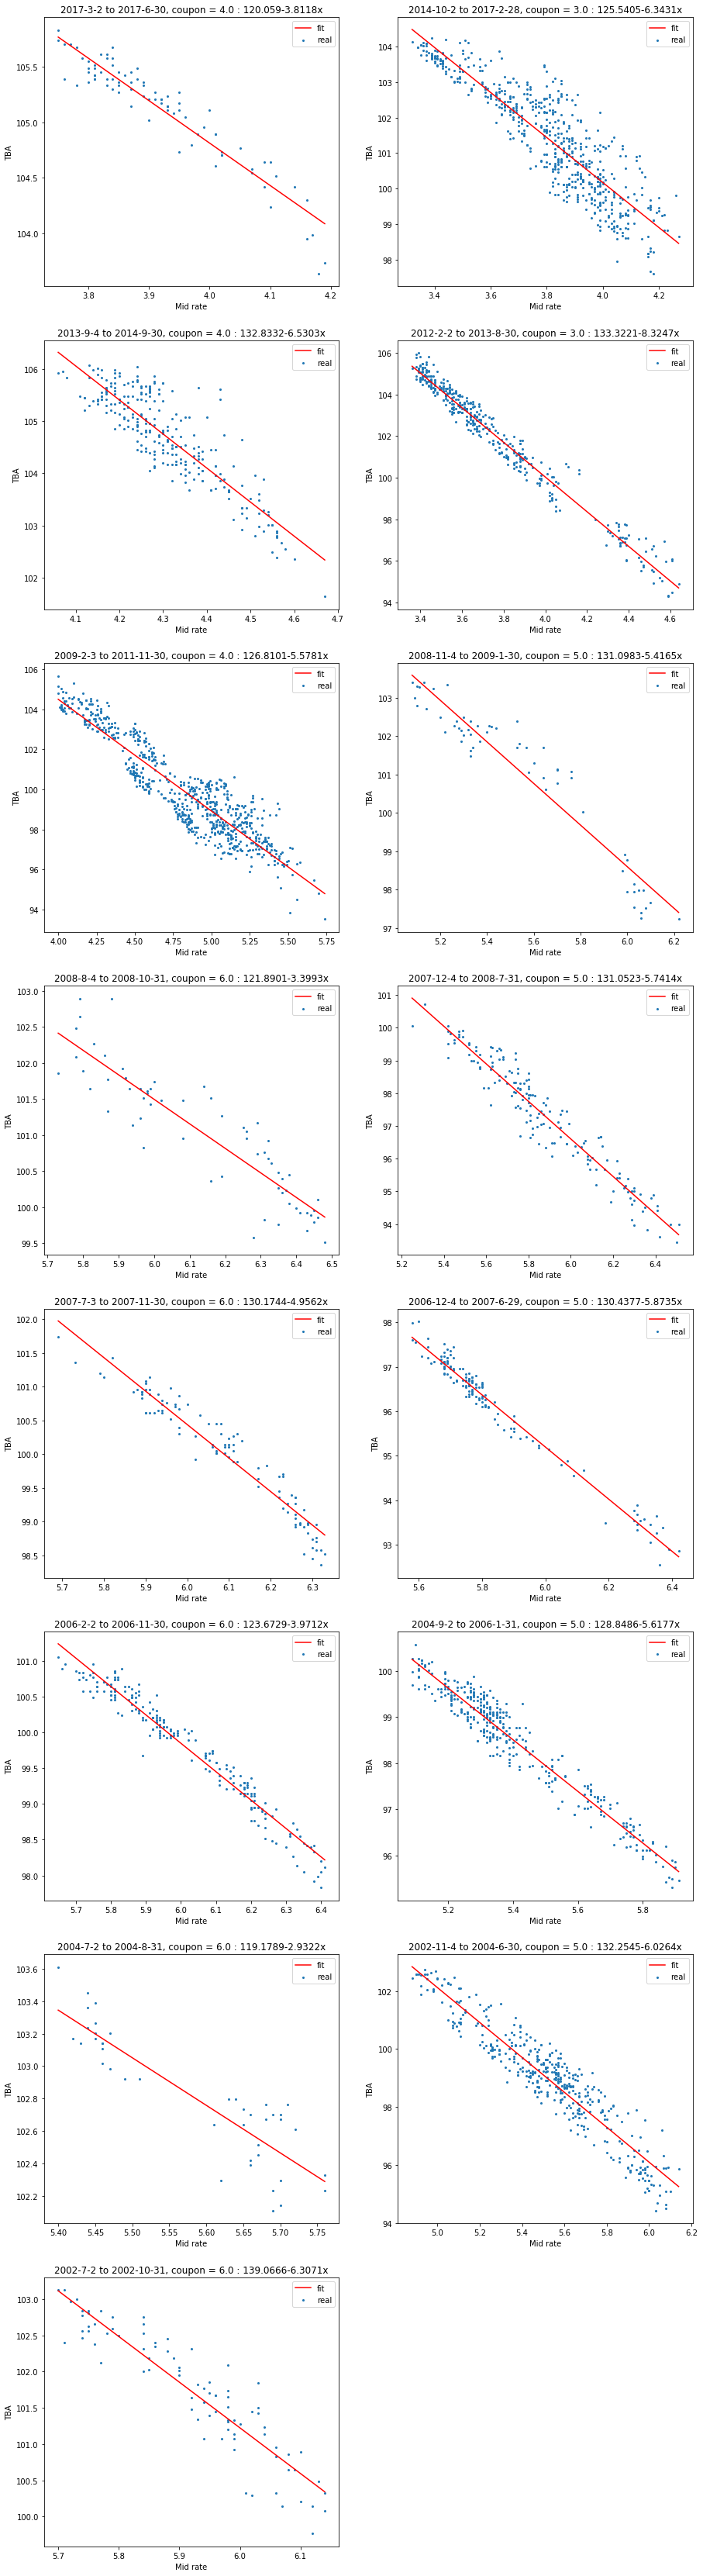

In [169]:
i = 1
fig = plt.figure(figsize = (15, 60))
ds2 = []
for s in samples:
    mod = sm.OLS(s['PX_MID'].values , sm.add_constant(s['Mid rate'].values))
    res = mod.fit()
    a, b = res.params
    x = np.linspace(min(s['Mid rate'].values),max(s['Mid rate'].values))
    y = [a+b*i for i in x]
    ax = fig.add_subplot(8,2,i)
    i = i + 1
    ax.plot(x, y,color = 'r',label='fit')
    ax.scatter(s['Mid rate'].values,s['PX_MID'].values,label = 'real',s=4)
    symb = ' + ' if b >= 0 else ''
    time_start = '{}-{}-{}'.format(s.iloc[s.shape[0] - 1].name.year, s.iloc[s.shape[0] - 1].name.month, s.iloc[s.shape[0] - 1].name.day)
    time_end = '{}-{}-{}'.format(s.iloc[0].name.year, s.iloc[0].name.month, s.iloc[0].name.day)
    ax.set_title(time_start + ' to ' + time_end + ', coupon = ' + str(s.iloc[0].coupon) + ' : ' + str(round(a, precision)) + symb + str(round(b, precision)) + 'x')
    ax.legend()
    ax.set_xlabel('Mid rate')
    ax.set_ylabel('TBA')
    
    ds2.append(pd.DataFrame({'Date' : s.index.values, 'Duration' : np.ones(s.shape[0]) * b}))

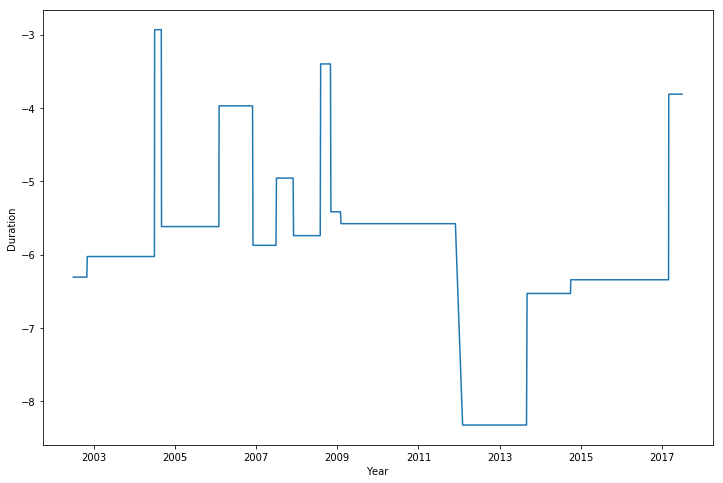

In [172]:
res = pd.concat(ds2)
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(res.Date, res.Duration)
ax.set_xlabel('Year')
ax.set_ylabel('Duration')

# 3. Conclusion

In this report, we analyzed the duration change over time using two rolling windows:
1. duration within each year
2. duration within each constant mostly issued coupon rate period

We observe that the duration does change over the time. The next step is to explore possible fundamental factors that cause this change.